In [ ]:
import logging
from typing import Any, Dict, Sequence, Union, Type, Optional, Callable, Literal
from pydantic import BaseModel
from langchain_core.tools import BaseTool
from ibm_watsonx_ai.metanames import GenTextParamsMetaNames as GenParams
from ibm_watsonx_ai.foundation_models.utils.enums import DecodingMethods
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.runnables import Runnable
from langchain_core.utils.function_calling import convert_to_openai_tool
from langchain_core.outputs import ChatGeneration, ChatGenerationChunk, ChatResult
from langchain_core.pydantic_v1 import BaseModel, Field, SecretStr, root_validator
from langchain_core.runnables import Runnable, RunnableMap, RunnablePassthrough
from langchain_core.tools import BaseTool
from langchain_core.messages import (BaseMessage,)
from langchain_core.output_parsers import ( JsonOutputParser,PydanticOutputParser,)
from langchain.output_parsers.openai_tools import PydanticToolsParser
from langchain.utils.openai_functions import convert_pydantic_to_openai_tool
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.language_models import LanguageModelInput
from langchain_core.language_models.chat_models import BaseChatModel
import json
from langchain_core.messages import ToolMessage
from langchain_ibm import WatsonxLLM as BaseWatsonxLLM

In [46]:
from ibm_watsonx_ai.metanames import GenTextParamsMetaNames as GenParams
from ibm_watsonx_ai.foundation_models.utils.enums import DecodingMethods
from langchain_ibm import WatsonxLLM
import json
import os
from dotenv import load_dotenv
# Environment setup
def _set_env(var: str):
    load_dotenv()  # Load environment variables from .env file
    env_var = os.getenv(var)
    if not env_var:
        env_var = getpass.getpass(f"{var}: ")
        os.environ[var] = env_var
    return env_var

api_key = _set_env("WATSONX_API_KEY")
project_id = _set_env("PROJECT_ID")
url = "https://us-south.ml.cloud.ibm.com"

In [37]:
from langchain_core.tools import tool
# Tool definition
@tool
def MyTool(text):
    """"My Tool
    """
    # Simulate processing time
    import time
    time.sleep(1)
    # Generate a random response
    import random
    responses = ['Response 1', 'Response 2', 'Response 3']
    return random.choice(responses)

In [40]:
MyTool.invoke("test")

'Response 3'

In [78]:
import logging
from typing import Any, Dict, Sequence, Union, Type, Optional, Callable, Literal
from pydantic import BaseModel
from langchain_core.tools import BaseTool, tool
from ibm_watsonx_ai.metanames import GenTextParamsMetaNames as GenParams
from ibm_watsonx_ai.foundation_models.utils.enums import DecodingMethods
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.runnables import Runnable
from langchain_ibm import WatsonxLLM as BaseWatsonxLLM
from langchain_core.utils.function_calling import convert_to_openai_tool
from langchain_core.outputs import ChatGeneration, ChatGenerationChunk, ChatResult
from langchain_core.pydantic_v1 import BaseModel, Field, SecretStr, root_validator
from langchain_core.runnables import Runnable, RunnableMap, RunnablePassthrough
from langchain_core.messages import (BaseMessage, ToolMessage,)
from langchain.output_parsers.openai_tools import PydanticToolsParser
from langchain.utils.openai_functions import convert_pydantic_to_openai_tool
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.language_models import LanguageModelInput
from langchain_core.language_models.chat_models import BaseChatModel
from ibm_watsonx_ai.metanames import GenTextParamsMetaNames as GenParams
from ibm_watsonx_ai.foundation_models.utils.enums import DecodingMethods
import json
import os
from dotenv import load_dotenv
logger = logging.getLogger(__name__)


class WatsonxLLM(BaseWatsonxLLM):
    """
    Extended IBM watsonx.ai large language models.
    """
    def bind_tools(
        self,
        tools: Sequence[Union[Dict[str, Any], Type[BaseModel], Callable, BaseTool]],
        *,
        tool_choice: Optional[
            Union[dict, str, Literal["auto", "none", "any", "required"], bool]
        ] = None,
        **kwargs: Any,
    ) -> Runnable[LanguageModelInput, BaseMessage]:
        """Bind tool-like objects to this chat model.

        Assumes model is compatible with OpenAI tool-calling API.

        Args:
            tools: A list of tool definitions to bind to this chat model.
                Can be  a dictionary, pydantic model, callable, or BaseTool. Pydantic
                models, callables, and BaseTools will be automatically converted to
                their schema dictionary representation.
            tool_choice: Which tool to require the model to call.
                Options are:
                name of the tool (str): calls corresponding tool;
                "auto": automatically selects a tool (including no tool);
                "none": does not call a tool;
                "any" or "required": force at least one tool to be called;
                True: forces tool call (requires `tools` be length 1);
                False: no effect;

                or a dict of the form:
                {"type": "function", "function": {"name": <<tool_name>>}}.
            **kwargs: Any additional parameters to pass to the
                :class:`~langchain.runnable.Runnable` constructor.
        """

        formatted_tools = [convert_to_openai_tool(tool) for tool in tools]
        if tool_choice:
            if isinstance(tool_choice, str):
                # tool_choice is a tool/function name
                if tool_choice not in ("auto", "none", "any", "required"):
                    tool_choice = {
                        "type": "function",
                        "function": {"name": tool_choice},
                    }
                # 'any' is not natively supported by OpenAI API.
                # We support 'any' since other models use this instead of 'required'.
                if tool_choice == "any":
                    tool_choice = "required"
            elif isinstance(tool_choice, bool):
                if len(tools) > 1:
                    raise ValueError(
                        "tool_choice=True can only be used when a single tool is "
                        f"passed in, received {len(tools)} tools."
                    )
                tool_choice = {
                    "type": "function",
                    "function": {"name": formatted_tools[0]["function"]["name"]},
                }
            elif isinstance(tool_choice, dict):
                tool_names = [
                    formatted_tool["function"]["name"]
                    for formatted_tool in formatted_tools
                ]
                if not any(
                    tool_name == tool_choice["function"]["name"]
                    for tool_name in tool_names
                ):
                    raise ValueError(
                        f"Tool choice {tool_choice} was specified, but the only "
                        f"provided tools were {tool_names}."
                    )
            else:
                raise ValueError(
                    f"Unrecognized tool_choice type. Expected str, bool or dict. "
                    f"Received: {tool_choice}"
                )
            kwargs["tool_choice"] = tool_choice
        return super().bind(tools=formatted_tools, **kwargs)

# Environment setup
def _set_env(var: str):
    load_dotenv()  # Load environment variables from .env file
    env_var = os.getenv(var)
    if not env_var:
        env_var = getpass.getpass(f"{var}: ")
        os.environ[var] = env_var
    return env_var

api_key = _set_env("WATSONX_API_KEY")
project_id = _set_env("PROJECT_ID")
url = "https://us-south.ml.cloud.ibm.com"    
# Create an instance of WatsonxLLM
# WatsonxLLM initialization
parameters = {
    GenParams.DECODING_METHOD: DecodingMethods.SAMPLE.value,
    GenParams.MAX_NEW_TOKENS: 500,
    GenParams.MIN_NEW_TOKENS: 50,
    GenParams.TEMPERATURE: 0.7,
    GenParams.TOP_K: 50,
    GenParams.TOP_P: 1
}
model_id = "ibm/granite-13b-instruct-v2"
watsonx_instance  = WatsonxLLM(
    model_id=model_id,
    url=url,
    apikey=api_key,
    project_id=project_id,
    params=parameters
)

# Tool definition
@tool
def MyTool(text):
    """My Tool"""
    # Simulate processing time
    import time
    time.sleep(1)
    # Generate a random response
    import random
    responses = ['Response 1', 'Response 2', 'Response 3']
    return random.choice(responses)



In [79]:


# Bind the tool to the instance
llm_with_tools = watsonx_instance.bind_tools([MyTool])

In [80]:


llm_with_tools.invoke("Who is Ruslan Magana?")

TypeError: ModelInference.generate() got an unexpected keyword argument 'tools'

In [81]:
watsonx_instance.invoke("Who is Ruslan Magana")

'ev?Ruslan Maganaev is a Russian professional ice hockey right wing currently playing for Sibir Novosibirsk in the Vysshaya Liga, the second level of ice hockey in Russia. He previously played for Traktor Chelyabinsk in the Vysshaya Liga from 2009–10 to 2011–12.'

In [7]:
import os
from langchain_core.messages import BaseMessage
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langgraph.graph import END, StateGraph
from langchain_openai import ChatOpenAI
from typing import Annotated, Sequence, TypedDict
from typing_extensions import TypedDict

In [8]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
# Create an agent
def create_agent(llm, tools, system_message: str):
    prompt = ChatPromptTemplate.from_messages([
        ("system", "You are a helpful AI assistant, collaborating with other assistants."),
        MessagesPlaceholder(variable_name="messages"),
    ])
    prompt = prompt.partial(system_message=system_message)
    prompt = prompt.partial(tool_names=", ".join([tool.name for tool in tools]))
    llm_instance = llm()
    return prompt | llm_instance.bind_tools(tools)
# Example usage
agent = create_agent(watsonx_instance, tools=[MyTool], system_message="You should provide a response.")

In [49]:

from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

# Create an agent
def create_agent(llm, tools, system_message: str):
    prompt = ChatPromptTemplate.from_messages([
        ("system", "You are a helpful AI assistant, collaborating with other assistants."),
        MessagesPlaceholder(variable_name="messages"),
    ])
    prompt = prompt.partial(system_message=system_message)
    prompt = prompt.partial(tool_names=", ".join([tool.name for tool in tools]))
    llm_instance = llm  # Pass the prompt to the llm instance
    return llm_instance.bind_tools(tools)

# Example usage
agent = create_agent(watsonx_instance, tools=[MyTool], system_message="You should provide a response.")


In [20]:
from langchain import hub
from langchain.agents import AgentExecutor, AgentType, initialize_agent, load_tools
from langchain_openai import ChatOpenAI

from langchain.agents.output_parsers.openai_tools import OpenAIToolsAgentOutputParser
from langchain.agents.format_scratchpad.openai_tools import (
    format_to_openai_tool_messages,
)
# Since chains can be stateful (e.g. they can have memory), we provide
# a way to initialize a new chain for each row in the dataset. This is done
# by passing in a factory function that returns a new chain for each row.
def create_agent(prompt, llm_with_tools):
    runnable_agent = (
        {
            "input": lambda x: x["input"],
            "agent_scratchpad": lambda x: format_to_openai_tool_messages(
                x["intermediate_steps"]
            ),
        }
        | prompt
        | llm_with_tools
        | OpenAIToolsAgentOutputParser()
    )
    return AgentExecutor(agent=runnable_agent, tools=tools, handle_parsing_errors=True)

In [22]:
from langchain.agents import AgentExecutor, create_openai_tools_agent
from langchain_core.messages import BaseMessage, HumanMessage
from langchain_openai import ChatOpenAI


def create_agent(llm: ChatOpenAI, tools: list, system_prompt: str):
    # Each worker node will be given a name and some tools.
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                system_prompt,
            ),
            MessagesPlaceholder(variable_name="messages"),
            MessagesPlaceholder(variable_name="agent_scratchpad"),
        ]
    )
    agent = create_openai_tools_agent(llm, tools, prompt)
    executor = AgentExecutor(agent=agent, tools=tools)
    return executor

In [24]:
# Example usage
agent = create_agent(watsonx_instance, tools=[MyTool], system_prompt="You should provide a response.")

In [25]:

# Define the nodes
def agent_node(state, agent, name):
    result = agent.invoke(state)
    if isinstance(result, BaseMessage):
        pass
    else:
        result = BaseMessage(**result.dict(exclude={"type", "name"}), name=name)
    return {
        "messages": [result],
        "sender": name,
    }

In [6]:
import os
from langchain_core.messages import BaseMessage
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langgraph.graph import END, StateGraph
from langchain_openai import ChatOpenAI
from typing import Annotated, Sequence, TypedDict
from typing_extensions import TypedDict

In [26]:


# Define the nodes
def agent_node(state, agent, name):
    result = agent.invoke(state)
    if isinstance(result, BaseMessage):
        pass
    else:
        result = BaseMessage(**result.dict(exclude={"type", "name"}), name=name)
    return {
        "messages": [result],
        "sender": name,
    }


In [27]:
class BasicToolNode:
    """A node that runs the tools requested in the last AIMessage."""

    def __init__(self, tools: list) -> None:
        self.tools_by_name = {tool.name: tool for tool in tools}

    def __call__(self, inputs: dict):
        if messages := inputs.get("messages", []):
            message = messages[-1]
        else:
            raise ValueError("No message found in input")
        outputs = []
        for tool_call in message.tool_calls:
            tool_result = self.tools_by_name[tool_call["name"]].invoke(
                tool_call["args"]
            )
            outputs.append(
                ToolMessage(
                    content=json.dumps(tool_result),
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )
        return {"messages": outputs}



In [28]:
tool_node = BasicToolNode(tools=[MyTool])

In [44]:
from typing import Annotated

from langchain_anthropic import ChatAnthropic
from typing_extensions import TypedDict

from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)

In [38]:
llm =watsonx_instance

In [45]:
tools = [MyTool]

In [82]:
# Modification: tell the LLM which tools it can call
llm_with_tools = llm.bind_tools(tools)

In [83]:
llm_with_tools.invoke("Who is Ruslan Magana?")

TypeError: ModelInference.generate() got an unexpected keyword argument 'tools'

In [39]:
def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}


In [40]:
# The first argument is the unique node name
# The second argument is the function or object that will be called whenever
# the node is used.
graph_builder.add_node("chatbot", chatbot)



In [41]:
MyTool.invoke("What's a 'node' in LangGraph?")

'Response 3'

In [42]:
import json

from langchain_core.messages import ToolMessage


class BasicToolNode:
    """A node that runs the tools requested in the last AIMessage."""

    def __init__(self, tools: list) -> None:
        self.tools_by_name = {tool.name: tool for tool in tools}

    def __call__(self, inputs: dict):
        if messages := inputs.get("messages", []):
            message = messages[-1]
        else:
            raise ValueError("No message found in input")
        outputs = []
        for tool_call in message.tool_calls:
            tool_result = self.tools_by_name[tool_call["name"]].invoke(
                tool_call["args"]
            )
            outputs.append(
                ToolMessage(
                    content=json.dumps(tool_result),
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )
        return {"messages": outputs}

In [35]:
tool_node = BasicToolNode(tools=[MyTool])

In [36]:
graph_builder.add_node("tools", tool_node)

Adding a node to a graph that has already been compiled. This will not be reflected in the compiled graph.


In [62]:
from typing import Literal


def route_tools(
    state: State,
) -> Literal["tools", "__end__"]:
    """Use in the conditional_edge to route to the ToolNode if the last message

    has tool calls. Otherwise, route to the end."""
    if isinstance(state, list):
        ai_message = state[-1]
    elif messages := state.get("messages", []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools"
    return "__end__"


In [63]:
# The `tools_condition` function returns "tools" if the chatbot asks to use a tool, and "__end__" if
# it is fine directly responding. This conditional routing defines the main agent loop.
graph_builder.add_conditional_edges(
    "chatbot",
    route_tools,
    # The following dictionary lets you tell the graph to interpret the condition's outputs as a specific node
    # It defaults to the identity function, but if you
    # want to use a node named something else apart from "tools",
    # You can update the value of the dictionary to something else
    # e.g., "tools": "my_tools"
    {"tools": "tools", "__end__": "__end__"},
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.set_entry_point("chatbot")
graph = graph_builder.compile()

UnboundLocalError: local variable 'node' referenced before assignment

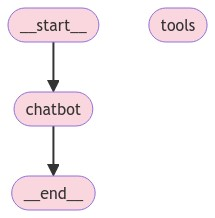

In [64]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except:
    # This requires some extra dependencies and is optional
    pass

In [65]:
from langchain_core.messages import BaseMessage

while True:
    user_input = input("User: ")
    if user_input.lower() in ["quit", "exit", "q"]:
        print("Goodbye!")
        break
    for event in graph.stream({"messages": [("user", user_input)]}):
        for value in event.values():
            if isinstance(value["messages"][-1], BaseMessage):
                print("Assistant:", value["messages"][-1].content)

Goodbye!
